## Preliminaries

In [1]:
import os
import matplotlib.pyplot as plt
import pickle
import re
import torch
from collections import Counter
from Bio import SeqIO # for reading FASTA files
from scripts.gen_embeddings import plot_embeddings, save_embeddings
from utilities.seq import invert_dict, aa_to_int_from_path
from utilities.vae import load_model, load_data
from utilities.utils import get_directory, parse_model_name

## Load data

In [2]:
MSA_id = "PF00144_og"
data_path = f"msas/real/processed/{MSA_id}"
model_name = "ding_layers1000_ld2_wd0.0_epoch500_2025-08-12.pt"
# For PF00144, each sequence has phylum labelled in this file
labelled_seq_fn = "msas/real/raw/PF00144_full_length_sequences_labeled.fasta"

In [3]:
# ## Binary representation
# with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
#     msa_binary = torch.tensor(pickle.load(file_handle))
# # for some reason, msa_binary is float64 so first transform it to float 32 for later use
# msa_binary = msa_binary.to(torch.float32)
# # Number of sequences
# n_total = msa_binary.shape[0]
# # Dimensions of one-hot encoding
# nl = msa_binary.shape[1]
# nc = msa_binary.shape[2]

# ## Sequences in integer format
# with open(f"{data_path}/seq_msa_int.pkl", 'rb') as file_handle:
#     real_seqs_int = pickle.load(file_handle)
# # Alternatively, since `argmax` works for extracting position of the 1 from the one hot encoded vectors:
# real_seqs_int2 = torch.argmax(msa_binary, -1)
# assert torch.tensor(real_seqs_int).equal(real_seqs_int2)
# print("integer format shape: ", real_seqs_int.shape)
# print("binary format shape: ", msa_binary.shape)

In [4]:
data, nl, nc = load_data(data_path, weigh_seqs=False, one_hot=True)
msa_binary, ids = data.msa, data.seq_keys

Load mapping between integers and amino acid characters

In [5]:
AA2IDX = aa_to_int_from_path(data_path)
IDX2AA = invert_dict(AA2IDX, unknown_symbol="-") 
print(AA2IDX)
print(IDX2AA)
nc = len(IDX2AA) # 20 or 21, depending on whether there are gaps in the MSA

{'-': 0, '.': 0, 'X': 0, 'B': 0, 'Z': 0, 'J': 0, 'R': 1, 'H': 2, 'K': 3, 'D': 4, 'E': 5, 'S': 6, 'T': 7, 'N': 8, 'Q': 9, 'C': 10, 'G': 11, 'P': 12, 'A': 13, 'V': 14, 'I': 15, 'L': 16, 'M': 17, 'F': 18, 'Y': 19, 'W': 20}
{0: '-', 1: 'R', 2: 'H', 3: 'K', 4: 'D', 5: 'E', 6: 'S', 7: 'T', 8: 'N', 9: 'Q', 10: 'C', 11: 'G', 12: 'P', 13: 'A', 14: 'V', 15: 'I', 16: 'L', 17: 'M', 18: 'F', 19: 'Y', 20: 'W'}


For PF00144, we have a file with the phyla of the species from which these protiens are obtained that we'll want to load in order to visualize the preservation of phylogeny by the embeddings:

In [6]:
phyla = {}
with open(labelled_seq_fn, 'r') as file_handle:
    for record in SeqIO.parse(file_handle, "fasta"):
        label = record.id
        phylum = re.search(r'\[([^\]]+)\]', record.description).group(1)
        phyla[label] = phylum
# order the phyla labels according to the order of sequences in our processed MSA (i.e. according to seq_names)
ordered_msa_phyla = []
for label in ids:
    label = label.split("/")[0]
    if label in phyla:
        ordered_msa_phyla.append(phyla[label])
    else:
        ordered_msa_phyla.append("Unknown")
# Count the number of sequences in each phylum
count = Counter(ordered_msa_phyla)
SORTED_PHYLA = sorted(count.items(), key=lambda item: item[1], reverse=True)
print(SORTED_PHYLA)

[('Actinobacteria', 6633), ('Proteobacteria', 5198), ('Bacteroidetes', 4035), ('Ascomycota', 2553), ('Firmicutes', 2286), ('Other', 761), ('Basidiomycota', 355), ('Nematoda (roundworms)', 204), ('Planctomycetes', 166), ('Cyanobacteria', 142), ('Euryarchaeota', 142), ('Chloroflexi', 132), ('Chordata', 124), ('Acidobacteria', 105), ('Streptophyta', 89), ('Verrucomicrobia', 65), ('Candidatus Aminicenantes', 58), ('Gemmatimonadetes', 47), ('Deinococcus-Thermus', 40), ('Ignavibacteriae', 38), ('Spirochaetes', 37), ('Mollusca', 36), ('Mucoromycota', 33), ('Arthropoda', 29), ('Lentisphaerae', 26), ('Chytridiomycota', 24), ('Armatimonadetes', 24), ('Tenericutes', 20), ('Balneolaeota', 19), ('Brachiopoda (lampshells)', 19), ('Chlorobi', 18), ('Unknown', 15), ('Platyhelminthes', 15), ('Rhodothermaeota', 13), ('Nitrospirae', 13), ('Chlamydiae', 13), ('Synergistetes', 11), ('Candidatus Heimdallarchaeota', 10), ('Crenarchaeota', 9), ('Candidatus Bathyarchaeota', 8), ('Candidatus Thorarchaeota', 8),

In [7]:
model_dir = get_directory(data_path, "saved_models")
model_path = os.path.join(model_dir, model_name)
is_trans, ld, layers, dim_aa_embed, one_hot = parse_model_name(model_path)
ding_model = model_name.startswith("ding")
model = load_model(model_path, nl=nl, nc=21, ding_model=ding_model,
                   num_hidden_units=layers, nlatent=ld, 
                   one_hot=one_hot, dim_aa_embed=dim_aa_embed, trans=is_trans)
model

VAE(
  (encoder_linears): ModuleList(
    (0): Linear(in_features=4809, out_features=1000, bias=True)
  )
  (encoder_mu): Linear(in_features=1000, out_features=2, bias=True)
  (encoder_logsigma): Linear(in_features=1000, out_features=2, bias=True)
  (decoder_linears): ModuleList(
    (0): Linear(in_features=2, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=4809, bias=True)
  )
)

## Visualize embeddings

In [8]:
with torch.no_grad():
    mu, sigma = model.encoder(msa_binary)
mu.shape

torch.Size([23698, 2])

In [9]:
save_embeddings(mu, torch.empty(0), ids, data_path, model_name)

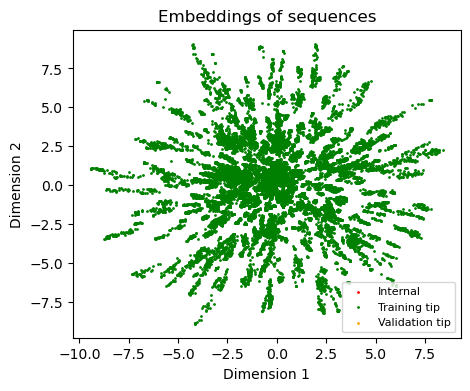

In [10]:
# PF00144 doesn't have valid_idx because was trained on Colab and we didn't save the indices of validation set
# with open(f"{model_dir}/valid_idx.pkl", 'rb') as file_handle:
#     valid_idx = pickle.load(file_handle)
plot_embeddings(mu, torch.empty(0), data_path, model_name, 
                #valid_idx=valid_idx
                )

For this family, we can color by the phylum of the species from which the sample is taken. Here's a function for plotting for this family

In [11]:
detlefsen_phyla_dict = {"Acidobacteria": "#693B9E", 
                        "Actinobacteria": "#FBCB90", 
                        "Bacteroidetes": "#E3181B",
                        "Chloroflexi": "#F3A19F", 
                        "Cyanobacteria": "#FA7F00", 
                        "Deinococcus-Thermus": "#A8CCE0", 
                        "Firmicutes": "#36A038", 
                        "Fusobacteria": "#B2E289", 
                        "Proteobacteria": "#147AB0"}



def plot_pf00144_embeddings(embeddings, phyla, plot_top=True, size=1, ax=None) -> None:
    """
    plot_top controls whether we plot the same phyla as detlefsen or the top 10 most common phyla
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    colors = set(detlefsen_phyla_dict.values())
    top_phyla_list = [phylum for phylum, _ in SORTED_PHYLA[:10] if phylum != "Other"]
    top_phyla_dict = {}
    # Assign the corresponding color to each phyla in the top_phyla_list as in detlefsen_phyla_dict
    for phylum in top_phyla_list:
        if phylum in detlefsen_phyla_dict:
            top_phyla_dict[phylum] = detlefsen_phyla_dict[phylum]
    # For the remaining phyla, assign a color that is not in the set of colors already used
    colors = list(colors - set(top_phyla_dict.values()) )
    for phylum in top_phyla_list:
        if phylum not in top_phyla_dict:
            top_phyla_dict[phylum] = colors.pop()
    phyla_dict = top_phyla_dict if plot_top else detlefsen_phyla_dict
    for phylum in phyla_dict:
        idx = [i for i, ph in enumerate(phyla) if ph == phylum]
        if idx: 
            ax.scatter(embeddings[idx, 0], embeddings[idx, 1], s=size, label=phylum, c = phyla_dict[phylum])
    return ax


Let's subset to only look at the embeddings of the representative sequencecs from the Detlefsen code

In [12]:
representative_point_labels = ['A0A1S9B261_9BACT', 'A0A1N6S5V9_9SPHI', 'A0A0G3XB70_9SPHN', 'A0A124H8F2_9ACTN', 'A0A0H0XMZ2_9SPHN', 'A0A1H3MS29_9MICO', 'A0A1C4RXZ6_9ACTN', 'K6YB53_9ALTE', 'D7BUJ0_STRBB', 'V4PEL1_9CAUL', 'A0A0R2T7U0_9GAMM', 'W6TRC3_9SPHI', 'A0A095V1K0_9FLAO', 'H5UKC9_9ACTN', 'A0A086GHA9_STRSC', 'I0K217_9BACT', 'A0A1E5SZ29_9BACT', 'A0A162YSP3_9FLAO', 'A0A1J4NQQ5_9ACTN', 'U5VSN6_9ACTN', 'A0A1C4SSD9_9ACTN', 'A0A1W9IDH3_9PROT', 'A0A142HQP5_9SPHI', 'A0A1S1R3M6_9ACTN', 'A0A1I1BJF2_9RHIZ', 'U5EQF0_NOCAS', 'A0A0X3XPR2_9ACTN', 'H6R079_NOCCG', 'A0A117P596_9ACTN', 'A0A1A1WA84_9MYCO', 'A0A0P1E0C4_9RHOB', 'A0A1A1W888_9MYCO', 'A0A1H7JGC4_9FLAO', 'A0A239H288_9ACTN', 'A0A1Q3TL54_9SPHI', 'K4KU84_SIMAS', 'A0A1I5UY06_9BURK', 'R1I1M6_9PSEU', 'Q1QJW4_NITHX', 'A0A132PRK9_9MYCO', 'A0A1U9RJ97_9PROT', 'A0A1M7RYP7_9SPHN', 'A0A1B2AFT2_9SPHN', 'A0A0A0M5Y1_9GAMM', 'A0A0F5VWV8_9ACTN', 'I2GLG1_9BACT', 'A0A0F7FX81_9ACTN', 'A0A1G8H815_9FLAO', 'A0A1X1XXI8_9MYCO', 'A0A239D989_9ACTN', 'A0A1V6MS15_9ACTN', 'A0A1H5P1R8_9ACTN', 'A0A1I5FZY5_9PSEU', 'A0A0X8G8M6_9FLAO', 'A0A0B4C4Z4_9RHOB', 'A0A1A3JFC6_9MYCO', 'F6FTL6_ISOV2', 'R6TPJ2_9FIRM', 'A0A0A8E0Q6_9XANT', 'A0A1I7E112_9BURK', 'A0A1I0K8Y1_9ACTN', 'A0A1Q5RAV8_9BRAD', 'A6GGG0_9DELT', 'F9UGM4_9GAMM', 'C1AR94_RHOOB', 'A0A1M5PIZ9_9PSED', 'A4YSH1_BRASO', 'A0A1C5D6B7_9ACTN', 'A0A1B9SCE0_9RHIZ', 'A0A1H5RFB9_9PSEU', 'A0A1H6K407_9FLAO', 'A0A1I5LQF8_9PSEU', 'A0A101P567_9ACTN', 'A0A1W9HH69_9PROT', 'A0A1C5GGB8_9ACTN', 'A0A1H9UFK4_9PSEU', 'C6XX09_PEDHD', 'A0A1N7D2Y2_9SPHI', 'A0A0M9ZF93_9ACTN', 'A0A1I3JVY2_9FLAO', 'A0A1Q5XM94_9BACL', 'A0A086GTC1_STRSC', 'A0A0Q3PHY5_9BRAD', 'X5L994_9MYCO', 'A8FUC9_SHESH', 'A0A1Q4AJT7_9RHIZ', 'A0A1R0U5T5_9MYCO', 'A0A239E4N3_9SPHN', 'A0A1W9Z6U0_9MYCO', 'A0A1E7N9T9_KITAU', 'A0A0D8ZT94_9CYAN', 'U5W069_9ACTN', 'A0A1X1TEX7_9MYCO', 'E3IVP0_FRAIE', 'A0A238W6P2_9FLAO', 'A0A0S2KGP0_9GAMM', 'A0A150X572_9BACT', 'A0A0P1HDX4_9RHOB', 'A0A1X1Y8Z0_9MYCO', 'A0A1T3NKX6_9ACTN', 'A0A1E5T8M3_9FLAO', 'W6RMK2_9RHIZ', 'D2QF15_SPILD', 'A0A172YP11_9GAMM', 'A0A1G9IS36_9FIRM', 'A0A0P0NER0_9SPHI', 'A0A1H2Z8U6_9FLAO', 'I4N9E9_9PSED', 'H6NNS0_9BACL', 'A0A0Q6U7Q0_9CAUL', 'A0A1I1NQA5_9FLAO', 'W6K0N3_9MICO', 'A0A059FAG0_9RHOB', 'A0A239UAQ6_9STAP', 'A0A0Q4CCW5_9SPHN', 'A0A1H7Z0C3_9BACL', 'I8XTV4_9BACE', 'A0A0Q9SNL5_9MICO', 'A0A0L0KUC6_9ACTN', 'A0A1M3DBI3_9SPHN', 'A0A0Q4CCV4_9FLAO', 'A0A0Q6LBM4_9RHIZ', 'A0A0D6P7R6_9PROT', 'A0A2D8REK4_9GAMM', 'A0A1I6MH08_9MICO', 'A0A1Z2KUI0_9ACTN', 'A5FKQ3_FLAJ1', 'A0A1I1L7I8_9GAMM', 'A0A1G9VIM6_9PSEU', 'A0A0K2YPP4_9NOCA', 'A0A172ZMD5_9BACL', 'A0A117P8A7_9ACTN', 'A0A0M2VW43_9BACL', 'A0A1X7LEJ3_9BACT', 'A0A1G8MTV3_9BRAD', 'A0A1G9UIX5_9ACTN', 'A0A2G1UKI9_9ALTE', 'A0A1I4ZAY4_9ACTN', 'A0A091BUD4_9ENTE', 'A0A1G9SC39_9BACT', 'A0A117QQC3_9ACTN', 'A0A246JGM2_9SPHN', 'G2YZY5_FLABF', 'A0A1A1XCB1_9MYCO', 'A0A1G6EYF3_9FLAO', 'A0A1W1UTZ2_9DEIO', 'A0A1H0LUA7_9PSEU', 'A0A0D7N702_9BRAD', 'A0A139V867_MYCPH', 'A0A0Q7T9N7_9CAUL', 'A0A075P8I6_9ALTE', 'F5XN73_MICPN', 'A0A1N6TB30_9ACTN', 'A0A0S2F7W1_9GAMM', 'A0A0W1FDQ5_9SPHN', 'A0A1F4HNF0_9BURK', 'A0A0S7B6I6_9CHLR', 'A0A1M7RNK4_9ACTN', 'D9VTC3_9ACTN', 'A0A1I4H5E7_9BACI', 'A0A1I6MHH8_9MICO', 'A0A0N1C0K0_9SPHN', 'A0A0S7BU80_9BACT', 'A0A1E5UCX4_9FLAO', 'A0A0T1QBY4_9ACTN', 'A0A1I7HTB7_9BRAD', 'A0A0J8YTA7_9BACT', 'A0A0Q5LNR9_9MICO', 'W6RC31_9RHIZ', 'A0A1H9IED7_9GAMM', 'A0A2C9XTS2_9ENTE', 'A0A0A7JHS1_9PSED', 'A0A0G3M0P2_9FLAO', 'A0A257J7M5_9PROT', 'A0A0Q4RYS2_9FLAO', 'A0A0X8E1F4_9MICO', 'A0A1H3JYW4_9ACTN', 'A0A1S8D874_9PROT', 'A0A1K2FJD7_9ACTN', 'A0A0M8XWS4_9ACTN', 'A0A1L7D1X1_9CORY', 'A0A0S2K5Z8_9GAMM', 'A0A1C2EAC3_9RHIZ', 'A0A086N7F9_9ACTN', 'A0A172TI00_9BACL', 'A0A1N7N8U5_9RHOB', 'A0A127JZQ8_9BURK', 'A0A0Q4MDP1_9GAMM', 'A0A074M2K7_9SPHN', 'A0A1S6FJP8_9SPHN', 'A0A1R1SC01_9ACTN', 'A0A1A3MVE7_MYCAS', 'B0T1W0_CAUSK', 'A0A0Q5UMQ3_9FLAO', 'K0ELR6_9NOCA', 'C9ZH94_STRSW', 'A0A100Y6W1_9ACTN', 'A0A1H4IQL5_9FLAO', 'A0A0M8XHR7_9ACTN', 'A0A1A1Y6V6_9MYCO']
label_to_indices = {}
for i, name in enumerate(ids):
    base = name.split('/')[0]
    label_to_indices[base] = i
rep_indices = [label_to_indices.get(lbl) for lbl in representative_point_labels]
rep_indices = [idx for idx in rep_indices if idx is not None]
print(f"No. of representative sequences that ended up in our processed MSA: {len(rep_indices)}/{len(representative_point_labels)}")
rep_embeds = mu[rep_indices, :]
rep_phyla = [ordered_msa_phyla[index] for index in rep_indices]
rep_labels = [ids[index] for index in rep_indices]
save_embeddings(rep_embeds, torch.empty(0), rep_labels, data_path, model_name, suffix="_rep-embeddings.csv")

No. of representative sequences that ended up in our processed MSA: 134/200


Now let's plot

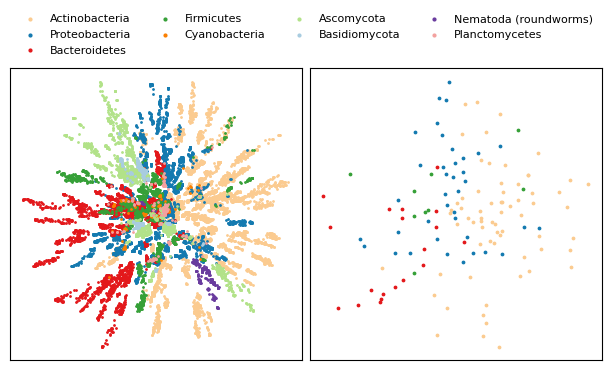

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
plot_pf00144_embeddings(mu, ordered_msa_phyla, ax=axes[0])
plot_pf00144_embeddings(rep_embeds, rep_phyla, ax=axes[1], size=3)
h, l = axes[0].get_legend_handles_labels()
fig.legend(h, l, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=4, fontsize = 8, markerscale=2, frameon=False)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
# axes[0].set_title('All embeddings')
# axes[1].set_title('Representative sequences')
plt.savefig("figures/PF00144_og/ding_layers1000_ld2_wd0.0_epoch500_2025-08-12/colored_embeddings.pdf", bbox_inches='tight')
